# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [19]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [20]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [21]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram

num_color_bins = 20 # Number of bins in the color histogram
#num_color_bins = 5 # Number of bins in the color histogram


feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [137]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
np.random.seed(1)
learning_rates = [ 0.1e-7]
regularization_strengths = [2e5, 3e5, 4e5, 5e5, 6e5, 7e5]

results = {}
best_val = -1
best_svm = None


svms = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, reg, num_iters=1000,
            batch_size=1000,  verbose = True)
        y_val_pred = svm.predict(X_val_feats)
        y_train_pred = svm.predict(X_train_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train == y_train_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        svms[(lr, reg)] = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_svm = svms[(lr, reg)]
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 340.582030
iteration 100 / 1000: loss 157.751769
iteration 200 / 1000: loss 75.733495
iteration 300 / 1000: loss 38.938532
iteration 400 / 1000: loss 22.430553
iteration 500 / 1000: loss 15.024800
iteration 600 / 1000: loss 11.702122
iteration 700 / 1000: loss 10.212476
iteration 800 / 1000: loss 9.543590
iteration 900 / 1000: loss 9.243822
iteration 0 / 1000: loss 526.966991
iteration 100 / 1000: loss 164.447444
iteration 200 / 1000: loss 55.649895
iteration 300 / 1000: loss 22.999567
iteration 400 / 1000: loss 13.201121
iteration 500 / 1000: loss 10.260646
iteration 600 / 1000: loss 9.378180
iteration 700 / 1000: loss 9.113525
iteration 800 / 1000: loss 9.034034
iteration 900 / 1000: loss 9.010180
iteration 0 / 1000: loss 643.651262
iteration 100 / 1000: loss 136.312962
iteration 200 / 1000: loss 34.538150
iteration 300 / 1000: loss 14.122697
iteration 400 / 1000: loss 10.027547
iteration 500 / 1000: loss 9.206172
iteration 600 / 1000: loss 9.041310
iteration

In [ ]:
numcolors = 10, lr 1.000000e-07 reg 3.000000e+05 train accuracy: 0.412878 val accuracy: 0.426000

    
 Testing with different number of bins in the color histogram did not help in increasing the cross validation accuracy

In [145]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


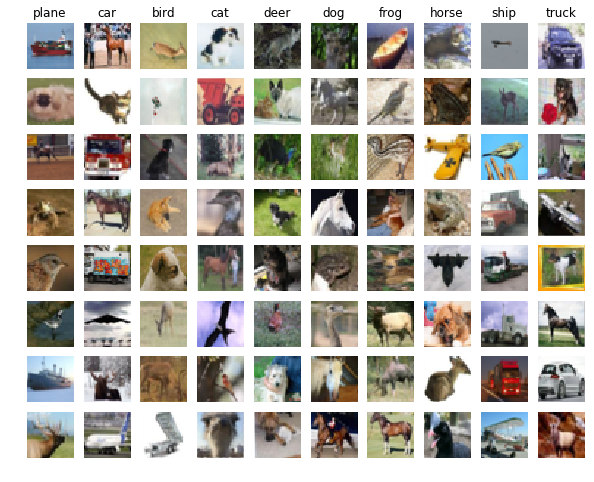

In [49]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

1) A lot of horses are misclassified as dogs. Similarly, dogs are misclassified as birds. This is perhaps because there are huge similarities between these classes and the current classifier is not able to find the features that differentiate these classes.  
2) Also, in case of some classes background plays an important role in misclassification. For example, as discussed in class, the plane class has misclassfied images with blue sky or blue water with ships and animals as belonging to plane class.
3)Similarly, in case of deer class, we see a lot of misclassified images with green grass in the background.
In conclusion, the classifier is not able to completely capture the important / defining entity of the image. This is expected as the input to our model is usually the entire image along with the background

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [55]:
print(X_train_feats.shape)

(49000, 155)


In [148]:
from cs231n.classifiers.neural_net import TwoLayerNet

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
np.random.seed(1)

input_dim = X_train_feats.shape[1]
hidden_dim = 100
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1   # The highest validation accuracy that we have seen so far.

results = {}


learning_rates = [1]
regularization_strengths = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
hidden_dims = [500, 1000, 2000]

nets = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_size in hidden_dims:
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=5000, batch_size=500,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=True)
            y_val_pred = net.predict(X_val_feats)
            y_train_pred = net.predict(X_train_feats)
            val_accuracy = np.mean(y_val == y_val_pred)
            train_accuracy = np.mean(y_train == y_train_pred)
            results[(lr, reg, hidden_size)] = (train_accuracy, val_accuracy)
            nets[(lr, reg, hidden_size)] = net

# Print out results.
for lr, reg, hidden_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_size)]
    print('lr %e reg %e hidden_size %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_net = nets[(lr, reg, hidden_size)]
        
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.348720
iteration 200 / 5000: loss 1.253894
iteration 300 / 5000: loss 1.105769
iteration 400 / 5000: loss 1.130997
iteration 500 / 5000: loss 1.113384
iteration 600 / 5000: loss 1.160106
iteration 700 / 5000: loss 1.016728
iteration 800 / 5000: loss 0.993270
iteration 900 / 5000: loss 0.927155
iteration 1000 / 5000: loss 0.955009
iteration 1100 / 5000: loss 0.939035
iteration 1200 / 5000: loss 0.849907
iteration 1300 / 5000: loss 0.905141
iteration 1400 / 5000: loss 0.919946
iteration 1500 / 5000: loss 0.917789
iteration 1600 / 5000: loss 0.837612
iteration 1700 / 5000: loss 0.887109
iteration 1800 / 5000: loss 0.837311
iteration 1900 / 5000: loss 0.766377
iteration 2000 / 5000: loss 0.931268
iteration 2100 / 5000: loss 0.853410
iteration 2200 / 5000: loss 0.803673
iteration 2300 / 5000: loss 0.713290
iteration 2400 / 5000: loss 0.801087
iteration 2500 / 5000: loss 0.861412
iteration 2600 / 5000: loss 0.918238
iteration 270

In [ ]:
Achieved validation accuracy of 58.5%
lr 1.000000e+00 reg 1.000000e-05 hidden_size 1.000000e+03 train accuracy: 0.661796 val accuracy: 0.575000
5000 iterations lr 1.000000e+00 reg 5.000000e-05 hidden_size 5.000000e+02 train accuracy: 0.735286 val accuracy: 0.585000


In [149]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.564


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [32]:
"""
We shall use drop out to see if the performance can be increased
But drop out did not increase any kind of performance
"""

from cs231n.classifiers.neural_net_dropout import TwoLayerNetWithDropOut
best_net_dropout = None # store the best model into this 
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
np.random.seed(1)

input_size = X_train_feats.shape[1]
hidden_size = 100
num_classes = 10

results = {}

net = TwoLayerNetWithDropOut(input_size, hidden_size, num_classes)

learning_rates = [1]
regularization_strengths = [ 5e-6 ]
hidden_dims = [1000]

nets = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_size in hidden_dims:
            net = TwoLayerNetWithDropOut(input_size, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=5000, batch_size=1024,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, do_dropout = False, dropout_percent = 0.1, verbose=True)
            y_val_pred = net.predict(X_val_feats)
            y_train_pred = net.predict(X_train_feats)
            val_accuracy = np.mean(y_val == y_val_pred)
            train_accuracy = np.mean(y_train == y_train_pred)
            results[(lr, reg, hidden_size)] = (train_accuracy, val_accuracy)
            nets[(lr, reg, hidden_size)] = net

# Print out results.
for lr, reg, hidden_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_size)]
    print('lr %e reg %e hidden_size %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_net_dropout = nets[(lr, reg, hidden_size)]
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)     




iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.316488
iteration 200 / 5000: loss 1.235285
iteration 300 / 5000: loss 1.208563
iteration 400 / 5000: loss 1.019711
iteration 500 / 5000: loss 0.997681
iteration 600 / 5000: loss 0.958719
iteration 700 / 5000: loss 0.932358
iteration 800 / 5000: loss 0.838519
iteration 900 / 5000: loss 0.840973
iteration 1000 / 5000: loss 0.672497
iteration 1100 / 5000: loss 0.647928
iteration 1200 / 5000: loss 0.591721
iteration 1300 / 5000: loss 0.648803
iteration 1400 / 5000: loss 0.583836
iteration 1500 / 5000: loss 0.613744
iteration 1600 / 5000: loss 0.583722
iteration 1700 / 5000: loss 0.541658
iteration 1800 / 5000: loss 0.535498
iteration 1900 / 5000: loss 0.474699
iteration 2000 / 5000: loss 0.506900
iteration 2100 / 5000: loss 0.531727
iteration 2200 / 5000: loss 0.450956
iteration 2300 / 5000: loss 0.549051
iteration 2400 / 5000: loss 0.466500
iteration 2500 / 5000: loss 0.322305
iteration 2600 / 5000: loss 0.565056
iteration 270

In [ ]:
lr 1.000000e+00 reg 1.000000e-06 hidden_size 5.000000e+02 train accuracy: 0.769367 val accuracy: 0.532000
lr 1.000000e+00 reg 1.000000e-06 hidden_size 1.000000e+03 train accuracy: 0.808837 val accuracy: 0.528000
lr 1.000000e+00 reg 1.000000e-06 hidden_size 2.000000e+03 train accuracy: 0.889633 val accuracy: 0.561000
lr 1.000000e+00 reg 5.000000e-06 hidden_size 5.000000e+02 train accuracy: 0.754551 val accuracy: 0.508000
lr 1.000000e+00 reg 5.000000e-06 hidden_size 1.000000e+03 train accuracy: 0.839327 val accuracy: 0.588000
lr 1.000000e+00 reg 5.000000e-06 hidden_size 2.000000e+03 train accuracy: 0.891510 val accuracy: 0.558000
lr 1.000000e+00 reg 1.000000e-05 hidden_size 5.000000e+02 train accuracy: 0.774735 val accuracy: 0.524000
lr 1.000000e+00 reg 1.000000e-05 hidden_size 1.000000e+03 train accuracy: 0.844980 val accuracy: 0.541000
lr 1.000000e+00 reg 1.000000e-05 hidden_size 2.000000e+03 train accuracy: 0.881796 val accuracy: 0.551000
lr 1.000000e+00 reg 5.000000e-05 hidden_size 5.000000e+02 train accuracy: 0.752347 val accuracy: 0.527000
lr 1.000000e+00 reg 5.000000e-05 hidden_size 1.000000e+03 train accuracy: 0.825714 val accuracy: 0.520000
lr 1.000000e+00 reg 5.000000e-05 hidden_size 2.000000e+03 train accuracy: 0.898694 val accuracy: 0.550000
lr 1.000000e+00 reg 1.000000e-04 hidden_size 5.000000e+02 train accuracy: 0.758082 val accuracy: 0.554000
lr 1.000000e+00 reg 1.000000e-04 hidden_size 1.000000e+03 train accuracy: 0.834857 val accuracy: 0.533000
lr 1.000000e+00 reg 1.000000e-04 hidden_size 2.000000e+03 train accuracy: 0.878408 val accuracy: 0.516000
        
lr 5.000000e-01 reg 5.000000e-06 hidden_size 7.500000e+02 train accuracy: 0.777959 val accuracy: 0.531000
lr 5.000000e-01 reg 5.000000e-06 hidden_size 1.000000e+03 train accuracy: 0.823673 val accuracy: 0.554000
lr 5.000000e-01 reg 5.000000e-06 hidden_size 1.250000e+03 train accuracy: 0.836204 val accuracy: 0.567000

In [30]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net_dropout.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.53


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [151]:
"""
We shall compare the classification performance from
1) HOG features and compare with HOG + Color histogram baseline
2) Color Histogram and compare with HOG + Color histogram baseline
"""



"""
Test Accuracy of HOG: 53%
Test Accuracy of Color: 27%
Test Accuracy of HOG + Color : 56.4%

The following experiments tell that while the individual performance of HOG is comparable to that of the
combined (HOG+color) performance, performance of color histogram is bad compared to (HOG + Color)


Hence, we can make a claim that its better to combine features to get improved performance over training
separately on HOG or Color features
However, this can also be due to the better hyperparameter tuning in combined case

"""



'\nWe shall compare the classification performance with just the \n1) HOG features and compare with HOG + Color histogram baseline\n2) Color Histogram and compare with HOG + Color histogram baseline\nThe following experiments tell that the individual performance of HOG and Color Histogram\nis comparable to that of their combined performance\n\n'

In [138]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
#num_color_bins = 20 # Number of bins in the color histogram
#num_color_bins = 5 # Number of bins in the color histogram


feature_fns = [hog_feature]
X_train_feats_hog = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_hog = extract_features(X_val, feature_fns)
X_test_feats_hog = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats_hog, axis=0, keepdims=True)
X_train_feats_hog -= mean_feat
X_val_feats_hog -= mean_feat
X_test_feats_hog -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats_hog, axis=0, keepdims=True)
X_train_feats_hog /= std_feat
X_val_feats_hog /= std_feat
X_test_feats_hog /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats_hog = np.hstack([X_train_feats_hog, np.ones((X_train_feats_hog.shape[0], 1))])
X_val_feats_hog = np.hstack([X_val_feats_hog, np.ones((X_val_feats_hog.shape[0], 1))])
X_test_feats_hog = np.hstack([X_test_feats_hog, np.ones((X_test_feats_hog.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [152]:
from cs231n.classifiers.neural_net import TwoLayerNet


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
np.random.seed(1)

input_dim = X_train_feats_hog.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1   # The highest validation accuracy that we have seen so far.

results = {}


learning_rates = [1]
regularization_strengths = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
hidden_dims = [500, 1000, 2000, 3000]
nets = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_size in hidden_dims:
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats_hog, y_train, X_val_feats_hog, y_val,
                num_iters=4000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=True)
            y_val_pred = net.predict(X_val_feats_hog)
            y_train_pred = net.predict(X_train_feats_hog)
            val_accuracy = np.mean(y_val == y_val_pred)
            train_accuracy = np.mean(y_train == y_train_pred)
            results[(lr, reg, hidden_size)] = (train_accuracy, val_accuracy)
            nets[(lr, reg, hidden_size)] = net

# Print out results.
for lr, reg, hidden_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_size)]
    print('lr %e reg %e hidden_size %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_net_hog = nets[(lr, reg, hidden_size)]
        
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss 1.393896
iteration 200 / 4000: loss 1.376823
iteration 300 / 4000: loss 1.335346
iteration 400 / 4000: loss 1.299410
iteration 500 / 4000: loss 1.148985
iteration 600 / 4000: loss 1.170635
iteration 700 / 4000: loss 1.208124
iteration 800 / 4000: loss 1.328966
iteration 900 / 4000: loss 1.206037
iteration 1000 / 4000: loss 0.979307
iteration 1100 / 4000: loss 0.947847
iteration 1200 / 4000: loss 0.916317
iteration 1300 / 4000: loss 0.831202
iteration 1400 / 4000: loss 0.733525
iteration 1500 / 4000: loss 0.897985
iteration 1600 / 4000: loss 0.957947
iteration 1700 / 4000: loss 0.765498
iteration 1800 / 4000: loss 0.680848
iteration 1900 / 4000: loss 0.803297
iteration 2000 / 4000: loss 0.774058
iteration 2100 / 4000: loss 0.629584
iteration 2200 / 4000: loss 0.746865
iteration 2300 / 4000: loss 0.558175
iteration 2400 / 4000: loss 0.664556
iteration 2500 / 4000: loss 0.526095
iteration 2600 / 4000: loss 0.649837
iteration 270

In [ ]:
1000 iterations lr 1.000000e+00 reg 1.000000e-06 hidden_size 5.000000e+02 train accuracy: 0.657776 val accuracy: 0.561000
4000 iterations lr 1.000000e+00 reg 1.000000e-04 hidden_size 3.000000e+03 train accuracy: 0.857367 val accuracy: 0.569000
best validation accuracy achieved during cross-validation: 0.556000


In [154]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net_hog.predict(X_test_feats_hog) == y_test).mean()
print(test_acc)

0.533


In [143]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
#num_color_bins = 20 # Number of bins in the color histogram
#num_color_bins = 5 # Number of bins in the color histogram


feature_fns = [ lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats_color = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_color = extract_features(X_val, feature_fns)
X_test_feats_color = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats_color, axis=0, keepdims=True)
X_train_feats_color -= mean_feat
X_val_feats_color -= mean_feat
X_test_feats_color -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats_color, axis=0, keepdims=True)
X_train_feats_color /= std_feat
X_val_feats_color /= std_feat
X_test_feats_color /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats_color = np.hstack([X_train_feats_color, np.ones((X_train_feats_color.shape[0], 1))])
X_val_feats_color = np.hstack([X_val_feats_color, np.ones((X_val_feats_color.shape[0], 1))])
X_test_feats_color = np.hstack([X_test_feats_color, np.ones((X_test_feats_color.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [173]:
from cs231n.classifiers.neural_net import TwoLayerNet


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
np.random.seed(1)

input_dim = X_train_feats_color.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1   # The highest validation accuracy that we have seen so far.

results = {}


learning_rates = [1]


regularization_strengths = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
hidden_dims = [500, 1000, 2000, 3000]
regularization_strengths = [5e-5]
hidden_dims = [1000]

nets = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_size in hidden_dims:
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats_color, y_train, X_val_feats_color, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=True)
            y_val_pred = net.predict(X_val_feats_color)
            y_train_pred = net.predict(X_train_feats_color)
            val_accuracy = np.mean(y_val == y_val_pred)
            train_accuracy = np.mean(y_train == y_train_pred)
            results[(lr, reg, hidden_size)] = (train_accuracy, val_accuracy)
            nets[(lr, reg, hidden_size)] = net

# Print out results.
for lr, reg, hidden_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_size)]
    print('lr %e reg %e hidden_size %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
    if best_val < val_accuracy :
        best_val = val_accuracy
        best_net_color = nets[(lr, reg, hidden_size)]
        
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.156804
iteration 200 / 2000: loss 2.089269
iteration 300 / 2000: loss 1.986996
iteration 400 / 2000: loss 1.978129
iteration 500 / 2000: loss 2.005415
iteration 600 / 2000: loss 1.990007
iteration 700 / 2000: loss 1.909282
iteration 800 / 2000: loss 1.992263
iteration 900 / 2000: loss 1.991628
iteration 1000 / 2000: loss 1.946143
iteration 1100 / 2000: loss 2.026092
iteration 1200 / 2000: loss 1.964286
iteration 1300 / 2000: loss 1.927806
iteration 1400 / 2000: loss 2.085047
iteration 1500 / 2000: loss 1.994978
iteration 1600 / 2000: loss 1.997737
iteration 1700 / 2000: loss 1.996552
iteration 1800 / 2000: loss 1.925707
iteration 1900 / 2000: loss 1.946056
lr 1.000000e+00 reg 5.000000e-05 hidden_size 1.000000e+03 train accuracy: 0.272776 val accuracy: 0.286000
best validation accuracy achieved during cross-validation: 0.286000


In [ ]:
lr 1.000000e+00 reg 5.000000e-06 hidden_size 2.000000e+03 train accuracy: 0.287490 val accuracy: 0.311000


In [159]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net_color.predict(X_test_feats_color) == y_test).mean()
print(test_acc)

0.269


In [1]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'